# Scenario similarity measures

In [82]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib2tikz import save as tikz_save
import os
import scipy
from scipy import linalg
from scipy import interpolate
from DynamicTimeWarping import DynamicTimeWarping
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
tikz_path = 'figures'
def tikz(name, extras=None):
    # Convert to tikz
    tikz_save(os.path.join(tikz_path, '{:s}.tikz'.format(name)),
              figureheight='\\figureheight', figurewidth='\\figurewidth',
              extra_axis_parameters=extras, show_info=False) 

In [84]:
# Define function for quickly making tables
table_folder = 'tabular'
tex_folder = 'tex'

def write(f, text):
    f.write(text)
    print(text, end="")
def str_e(x, decimals=1):
    if x >= 1 and x < 10:
        return '{:.{decimals}f}'.format(x, decimals=decimals)
    else:
        exp = np.floor(np.log10(x)).astype(np.int)
        return '{:.{decimals}f} \\cdot 10^{{{:d}}}'.format(x / 10.**exp, exp, decimals=decimals)

In [85]:
# Define method for looping through set of profiles and print score
def table_distance(V, func, **kwargs):
    nv = len(V)
    print("  ", end="")
    for i in range(nv):
        print(" {:7d}".format(i+1), end="")
    print("")
    for i in range(nv):
        print("{:2d}".format(i+1), end="")
        for j in range(nv):
            if i == j:
                print(" {:7s}".format(""), end="")
            else:
                print(" {:7.1e}".format(func(V[i], V[j], **kwargs)), end="")
        print("")

## Create two example figures

In [86]:
with open(os.path.join('..', '20171126 Parametrization', 'df.p'), 'rb') as f:
    (dfs, scaling) = pickle.load(f)
# Only use first n profiles
n = len(dfs)
dfs = dfs[:n].copy()
scaling = scaling.T[:n].copy()

Average deceleration: 3.19 m/s^2
Average deceleration: 1.72 m/s^2
Average deceleration: 1.63 m/s^2
Average deceleration: 1.64 m/s^2
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


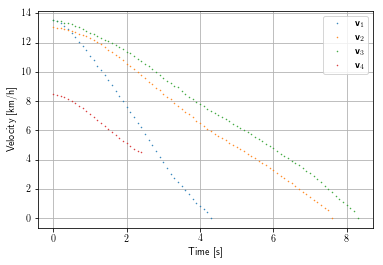

In [88]:
# Show a profile
# 322: hardest braking
# 292: Looks most at 322 when only looking at start and end velocity
# 143: Looks very similar to 292
# 381: Acceleratin similar to 292, but much shorter
ii = [322, 143, 292, 381]
ts = 0.1
V = []
A = []
for j, i in enumerate(ii):
    t = dfs[i]['time']*scaling[i, 0]
    v = (dfs[i]['vel']*(scaling[i, 1] - scaling[i, 2]) + scaling[i, 2])
    tnew = np.arange(t.values[0], np.ceil(t.values[-1] / ts)+1) * ts
    vnew = np.interp(tnew, t, v)
    V.append(vnew)
    A.append(np.gradient(vnew) / ts)
    plt.plot(tnew, vnew, '.', label=r"$\textbf{{v}}_{:d}$".format(j+1), ms=1)
    print("Average deceleration: {:.2f} m/s^2".format((scaling[i, 1] - scaling[i, 2]) / scaling[i, 0]))
plt.grid('on')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [km/h]')
plt.legend()
tikz('velocity_profile_example')

In [7]:
# We will resample all profiles, as we have to use them
dfs_resampled = []
for i, df in enumerate(dfs):
    t = df['time']*scaling[i, 0]
    v = (df['vel']*(scaling[i, 1] - scaling[i, 2]) + scaling[i, 2])
    tnew = np.arange(t.values[0], np.ceil(t.values[-1] / ts)+1) * ts
    vnew = np.interp(tnew, t, v)
    dfs_resampled.append(pd.DataFrame(np.array([tnew, vnew]).T, columns=['time', 'vel']))

## Euclidean distance

In [8]:
def lp(xx, yy, p):
    # Sample yy to have the same number of elements
    yy = np.interp(np.linspace(0, len(yy), len(xx)), np.arange(0, len(yy)), yy)
    
    # Compute the norm
    return np.sum(np.abs(xx - yy)**p) ** (1/p)

def euclidean(xx, yy):
    return lp(xx, yy, 2)

In [9]:
n = len(V)
for i in range(n):
    for j in range(n):
        if not i == j:
            print("Deuclidean({:d},{:d}) = {:.1f}".format(i+1, j+1, euclidean(V[i], V[j])))

Deuclidean(1,2) = 2.4
Deuclidean(1,3) = 4.4
Deuclidean(1,4) = 20.0
Deuclidean(2,1) = 4.7
Deuclidean(2,3) = 4.2
Deuclidean(2,4) = 23.6
Deuclidean(3,1) = 8.6
Deuclidean(3,2) = 5.9
Deuclidean(3,4) = 26.1
Deuclidean(4,1) = 15.7
Deuclidean(4,2) = 14.1
Deuclidean(4,3) = 14.7


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


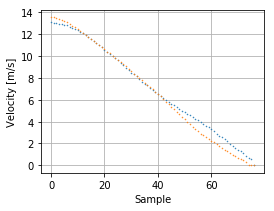

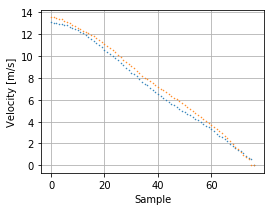

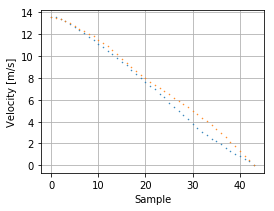

In [10]:
for i, j in zip([1, 1, 0], [0, 2, 2]):
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(V[i], '.', label='Profile {:d}'.format(i+1), ms=1)
    ax.plot(np.interp(np.linspace(0, len(V[j]), len(V[i])), np.arange(0, len(V[j])), V[j]), '.', 
            label='Profile {:d}'.format(j+1), ms=1)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Velocity [m/s]')
    ax.grid('on')
    tikz('velocity_profiles_resampled{:d}{:d}'.format(i+1, j+1))

## Feature-based

### Fourier coefficients

In [11]:
def fft(x):
    X = np.fft.rfft(x)
    f = np.arange(np.floor(len(x)/2)+1) / (len(x) * ts)
    return f, X
def fft_at_freq(x, freqs):
    f, X = fft(x)
    return np.interp(freqs, f, X)
def fourier_based_distance(x, y, w=None):
    xhat = fft_at_freq(x, freq) / len(x)
    yhat = fft_at_freq(y, freq) / len(y)
    if w is None:  # Use default weights in this case
        w = [1/100, 1, 1, 1]
    return np.sqrt(np.sum(w*np.abs(xhat - yhat)**2))

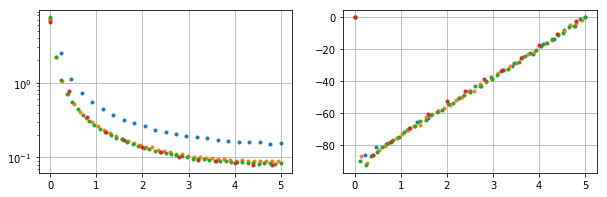

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
for v in V:
    f, X = fft(v)
    ax1.semilogy(f, np.abs(X)/len(v), '.')
    ax2.plot(f, np.angle(X)/np.pi*180, '.')
ax1.grid('on')
ax2.grid('on')

In [13]:
# Compute fourier coefficients for all profiles
freq = [0, 0.5, 1, 1.5]
FCs = np.array([fft_at_freq(df['vel'], freq)/len(df['vel']) for df in dfs_resampled])
FCweights = 1 / np.std(FCs, axis=0) ** 2

In [14]:
# Write weights to tex file
with open(os.path.join(tex_folder, 'FC_weights.tex'), 'w') as f:
    for i, w in enumerate(FCweights):
        if i == len(FCweights)-1:
            write(f, 'and ')
        write(f, '$w_{{{:d}}}=\\unit[{:s}]{{s^2/m^2}}'.format(i, str_e(w)))
        write(f, '$')
        if i < len(FCweights)-1:
            write(f, ', ')
    write(f, '.')

$w_{0}=\unit[4.5 \cdot 10^{-2}]{s^2/m^2}$, $w_{1}=\unit[1.1 \cdot 10^{1}]{s^2/m^2}$, $w_{2}=\unit[2.1 \cdot 10^{2}]{s^2/m^2}$, and $w_{3}=\unit[4.9 \cdot 10^{2}]{s^2/m^2}$.

In [15]:
table_distance(V, fourier_based_distance, w=FCweights)

         1       2       3       4
 1         5.2e+00 5.5e+00 5.0e+00
 2 5.2e+00         3.0e-01 4.6e-01
 3 5.5e+00 3.0e-01         6.3e-01
 4 5.0e+00 4.6e-01 6.3e-01        


In [16]:
with open(os.path.join(table_folder, 'fourier_coefficients.tex'), 'w') as f:
    write(f, '\\begin{tabular}{crrrr}\n')
    write(f, '    \\toprule\n')
    write(f, '    Time    & \\multicolumn{3}{c}{Fourier coefficients} \\\\\n')
    write(f, '    series ')
    for fr in freq:
        write(f, ' & $\\unit[{:.1f}]{{Hz}}$'.format(fr))
    write(f, ' \\\\\\otoprule\n')
    for i, v in enumerate(V):
        F = fft_at_freq(v, freq) / len(v)
        f_real = np.real(F)
        f_imag = np.imag(F)
        write(f, '    $\\profile{{{:d}}}$'.format(i+1))
        for real, imag in zip(f_real, f_imag):
            write(f, ' & ${:.2f}{:s}{:.2f}\\imagi$'.format(real, '+' if imag >= 0 else '-', np.abs(imag)))
        write(f, ' \\\\\n')
    write(f, '    \\bottomrule\n')
    write(f, '\\end{tabular}\n')

\begin{tabular}{crrrr}
    \toprule
    Time    & \multicolumn{3}{c}{Fourier coefficients} \\
    series  & $\unit[0.0]{Hz}$ & $\unit[0.5]{Hz}$ & $\unit[1.0]{Hz}$ & $\unit[1.5]{Hz}$ \\\otoprule
    $\profile{1}$ & $6.99+0.00\imagi$ & $0.17-1.04\imagi$ & $0.14-0.50\imagi$ & $0.15-0.31\imagi$ \\
    $\profile{2}$ & $7.09+0.00\imagi$ & $0.06-0.54\imagi$ & $0.07-0.26\imagi$ & $0.08-0.17\imagi$ \\
    $\profile{3}$ & $7.60+0.00\imagi$ & $0.06-0.53\imagi$ & $0.07-0.25\imagi$ & $0.08-0.16\imagi$ \\
    $\profile{4}$ & $6.64+0.00\imagi$ & $0.05-0.66\imagi$ & $0.07-0.27\imagi$ & $0.08-0.16\imagi$ \\
    \bottomrule
\end{tabular}


### Parameters

In [17]:
# Determine parameters for all time series
par_all = np.array([[df['vel'][0], 
                     df['vel'].values[-1], 
                     df['vel'][0] - df['vel'].values[-1], 
                     df['time'].values[-1]] for df in dfs_resampled])
w = 1 / np.std(par_all, axis=0)**2
par_weights = [w[3], w[2], w[1]]  # Only take weights for time difference, velocity difference, and velocity reduction
par_w_units = ['s^{-2}', 's^2/m^2', 's^2/m^2']

In [18]:
# Write weights to tex file
with open(os.path.join(tex_folder, 'custom_par_weights.tex'), 'w') as f:
    for i, (w, u) in enumerate(zip(par_weights, par_w_units)):
        if i == len(par_weights)-1:
            write(f, 'and ')
        write(f, '$w_{{{:d}}}=\\unit[{:s}]{{{:s}}}'.format(i, str_e(w), u))
        write(f, '$')
        write(f, ', ')
    write(f, 'respectively.')

$w_{0}=\unit[9.3 \cdot 10^{-2}]{s^{-2}}$, $w_{1}=\unit[5.2 \cdot 10^{-2}]{s^2/m^2}$, and $w_{2}=\unit[3.3 \cdot 10^{-2}]{s^2/m^2}$, respectively.

In [19]:
# Time duration, velocity difference, end velocity
def parameter_based_distance(x, y, w=None):
    x_dt = (len(x) - 1) * ts
    y_dt = (len(y) - 1) * ts
    x_dv = np.max(x) - np.min(x)
    y_dv = np.max(y) - np.min(y)
    x_ve = x[-1]
    y_ve = y[-1]
    
    if w is None:
        w_dt = 1
        w_dv = 0.2
        w_ve = 0.2
    else:
        w_dt, w_dv, w_ve = w
    
    return np.sqrt(w_dt*(x_dt-y_dt)**2 + w_dv*(x_dv-y_dv)**2 + w_ve*(x_ve-y_ve)**2)
table_distance(V, parameter_based_distance, w=par_weights)

         1       2       3       4
 1         1.0e+00 1.2e+00 2.4e+00
 2 1.0e+00         2.4e-01 2.8e+00
 3 1.2e+00 2.4e-01         3.0e+00
 4 2.4e+00 2.8e+00 3.0e+00        


In [20]:
# Make a table with the parameters
with open(os.path.join(table_folder, 'scenario_parameters.tex'), 'w') as f:
    write(f, '\\begin{tabular}{crrrr}\n')
    write(f, '    \\toprule\n')
    write(f, '    Time & \\multicolumn{4}{c}{Parameters} \\\\\n')
    write(f, '    series & $\\parvstart\,[\\unit{m/s}]$ & $\\parvend\,[\\unit{m/s}]$')
    write(f, ' & $\\pardv\,[\\unit{m/s}]$ & $\\pardt\,[\\unit{s}]$ \\\\\\otoprule\n')
    for i, v in enumerate(V):
        write(f, '    $\\profile{{{:d}}}$ & {:.1f} & {:.1f}'.format(i+1, v[0], v[-1]))
        write(f, ' & {:.1f} & {:.1f} \\\\\n'.format(v[0]-v[-1], (len(v)-1)*ts))
    write(f, '    \\bottomrule\n')
    write(f, '\\end{tabular}\n')

\begin{tabular}{crrrr}
    \toprule
    Time & \multicolumn{4}{c}{Parameters} \\
    series & $\parvstart\,[\unit{m/s}]$ & $\parvend\,[\unit{m/s}]$ & $\pardv\,[\unit{m/s}]$ & $\pardt\,[\unit{s}]$ \\\otoprule
    $\profile{1}$ & 13.5 & 0.0 & 13.5 & 4.3 \\
    $\profile{2}$ & 13.1 & 0.0 & 13.1 & 7.6 \\
    $\profile{3}$ & 13.5 & 0.0 & 13.5 & 8.3 \\
    $\profile{4}$ & 8.5 & 4.5 & 3.9 & 2.4 \\
    \bottomrule
\end{tabular}


### Splines

In [21]:
# Note, time has no influence
def spl_coef(x, k=1):  # k=number of interior knots
    t = np.arange(len(x))*ts
    knots = np.linspace(0, t[-1], k+2)[1:-1]
    t, c, d = interpolate.splrep(t, x, t=knots)
    nr_coefficients = k + 4
    return c[:nr_coefficients]
def spl_distance(x, y, k=1, w=None):
    cx = spl_coef(x, k=k)
    tx = (len(x) - 1)*ts
    par_x = np.concatenate(([tx], cx))
    cy = spl_coef(y, k=k)
    ty = (len(x) - 1)*ts
    par_y = np.concatenate(([ty], cy))
    if w is None:
        w = np.ones(len(par_x))
    return np.sum(w * (par_x - par_y)**2)

In [22]:
# Compute spline coefficients for all time series
spl_coefs = np.array([spl_coef(df['vel']) for df in dfs_resampled])
tduration = np.array([df['time'].values[-1] for df in dfs_resampled])  # Compute tduration, because we will add this as parameter
spl_weights = 1 / np.concatenate(([np.std(tduration)], np.std(spl_coefs, axis=0)))**2

In [23]:
# Print weights to tex file
with open(os.path.join(tex_folder, 'spl_weights.tex'), 'w') as f:
    write(f, 'The associated weight for the length of the time series is $w_0=\\unit[{:s}]{{s^{{-2}}}}$.\n'.format(str_e(spl_weights[0])))
    write(f, 'For the spline coefficients $c_1$ through $c_{{{:d}}}$, the weights are '.format(len(spl_weights)-1))
    for i, w in enumerate(spl_weights[1:]):
        if i == len(spl_weights)-2:
            write(f, 'and ')
        write(f, '$w_{{{:d}}}=\\unit[{:s}]{{s^2/m^2}}$, '.format(i+1, str_e(w)))
    write(f, 'respectively.')

The associated weight for the length of the time series is $w_0=\unit[9.3 \cdot 10^{-2}]{s^{-2}}$.
For the spline coefficients $c_1$ through $c_{5}$, the weights are $w_{1}=\unit[4.0 \cdot 10^{-2}]{s^2/m^2}$, $w_{2}=\unit[4.0 \cdot 10^{-2}]{s^2/m^2}$, $w_{3}=\unit[4.2 \cdot 10^{-2}]{s^2/m^2}$, $w_{4}=\unit[3.9 \cdot 10^{-2}]{s^2/m^2}$, and $w_{5}=\unit[3.4 \cdot 10^{-2}]{s^2/m^2}$, respectively.

In [24]:
# Make a table with the parameters
with open(os.path.join(table_folder, 'spline_parameters.tex'), 'w') as f:
    write(f, '\\begin{tabular}{crrrrrr}\n')
    write(f, '    \\toprule\n')
    write(f, '    Time & $\\pardt\,[\\unit{s}]$ & \\multicolumn{5}{c}{Spline parameters} \\\\\n')
    write(f, '    series &')
    for i in range(5):  # 5 spline parameters
        write(f, ' & $c_{{{:d}}}\,[\\unit{{m/s}}]$'.format(i+1))
    write(f, ' \\\\\\otoprule\n')
    for i, v in enumerate(V):
        write(f, '    $\\profile{{{:d}}}$ & {:.1f}'.format(i+1, (len(v)-1)*ts))
        for c in spl_coef(v):
            write(f, ' & {:.1f}'.format(c))
        write(f, ' \\\\\n')
    write(f, '    \\bottomrule\n')
    write(f, '\\end{tabular}\n')

\begin{tabular}{crrrrrr}
    \toprule
    Time & $\pardt\,[\unit{s}]$ & \multicolumn{5}{c}{Spline parameters} \\
    series & & $c_{1}\,[\unit{m/s}]$ & $c_{2}\,[\unit{m/s}]$ & $c_{3}\,[\unit{m/s}]$ & $c_{4}\,[\unit{m/s}]$ & $c_{5}\,[\unit{m/s}]$ \\\otoprule
    $\profile{1}$ & 4.3 & 13.7 & 12.4 & 7.2 & 1.5 & 0.2 \\
    $\profile{2}$ & 7.6 & 13.1 & 12.9 & 5.7 & 3.2 & 0.1 \\
    $\profile{3}$ & 8.3 & 13.5 & 13.0 & 6.7 & 3.9 & 0.1 \\
    $\profile{4}$ & 2.4 & 8.5 & 8.4 & 6.8 & 5.0 & 4.5 \\
    \bottomrule
\end{tabular}


In [25]:
table_distance(V, spl_distance, w=spl_weights)

         1       2       3       4
 1         2.3e-01 2.5e-01 2.9e+00
 2 2.3e-01         7.1e-02 2.5e+00
 3 2.5e-01 7.1e-02         2.6e+00
 4 2.9e+00 2.5e+00 2.6e+00        


### Auto-regressive models

Problem that duration is not taken into account

In [26]:
def ar(x, n=3):
    A = np.zeros((len(x)-n+1, n))
    A[:, 0] = 1
    for i in range(1, n):
        A[:, i] = x[n-i-1:-i]
    b = x[n-1:]
    return np.linalg.lstsq(A, b)[0]
def ar_distance(x, y, n=3, w=None):
    xhat = ar(x, n=n)
    yhat = ar(y, n=n)
    if w is None:
        w = np.ones(n)
    return np.sqrt(np.sum(w * (xhat - yhat)**2))

In [27]:
# Alternative method using Yule-Walker method
class YW(object):
    """A class to fit AR model using Yule-Walker method"""

    def __init__(self, X):
        self.X = X - np.mean(X)
        
    def autocorr(self, lag=3):
        c = np.correlate(self.X, self.X, 'full')
        mid = len(c)//2
        acov = c[mid:mid+lag]
        acor = acov/acov[0]
        return acor
    
    def fit(self, p=3):
        ac = self.autocorr(p+1)
        R = linalg.toeplitz(ac[:p])
        r = ac[1:p+1]
        self.phi = np.linalg.solve(R, r)
yw = YW(V[0])
print(yw.autocorr())
yw.fit()
yw.phi  # What does this mean? It is completely different from the previous method...

[ 1.          0.94152917  0.88139849]


array([ 0.98141263,  0.00446938, -0.05002448])

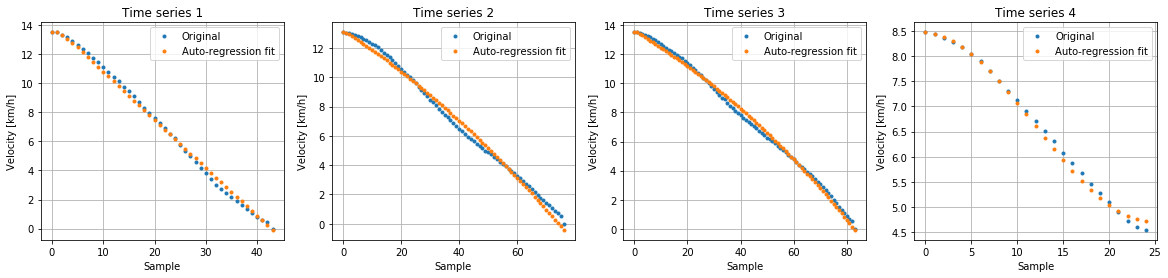

In [28]:
f, axs = plt.subplots(1, len(V), figsize=(5*len(V), 4))
n_ar = 3
A = []
for j, (v, ax) in enumerate(zip(V, axs)):
    a = ar(v/3.6, n=n_ar)
    A.append(a)
    y = np.zeros_like(v)
    y[:n_ar-1] = v[:n_ar-1] / 3.6
    for i in range(n_ar-1, len(y)):
        y[i] = a[0] + np.sum(np.flipud(a[1:]) * y[i-n_ar+1:i])
    y *= 3.6
    ax.plot(v, '.', label='Original')
    ax.plot(y, '.', label='Auto-regression fit')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Velocity [km/h]')
    ax.set_title('Time series {:d}'.format(j+1))
    ax.grid('on')
    ax.legend()

In [29]:
with open(os.path.join(table_folder, 'ar_coefficients.tex'), 'w') as f:
    write(f, '\\begin{tabular}{crrr}\n')
    write(f, '    \\toprule\n')
    write(f, '    Time    & \\multicolumn{3}{c}{Auto-regression coefficients} \\\\\n')
    write(f, '    series & $a_0\,[\\unit{m/s}]$ & $a_1$ & $a_2$ \\\\ \\otoprule\n')
    for i, aa in enumerate(A):
        write(f, '    $\\profile{{{:d}}}$'.format(i+1))
        for a in aa:
            write(f, ' & {:.2f}'.format(a))
        write(f, ' \\\\\n')
    write(f, '    \\bottomrule\n')
    write(f, '\\end{tabular}\n')

\begin{tabular}{crrr}
    \toprule
    Time    & \multicolumn{3}{c}{Auto-regression coefficients} \\
    series & $a_0\,[\unit{m/s}]$ & $a_1$ & $a_2$ \\ \otoprule
    $\profile{1}$ & -0.04 & 1.50 & -0.50 \\
    $\profile{2}$ & -0.03 & 1.58 & -0.57 \\
    $\profile{3}$ & -0.05 & 1.21 & -0.21 \\
    $\profile{4}$ & 0.03 & 1.98 & -1.00 \\
    \bottomrule
\end{tabular}


In [30]:
ar_coefficients = np.array([ar(df['vel'], n=n_ar) for df in dfs_resampled])
ar_weights = 1 / np.std(ar_coefficients, axis=0)**2
with open(os.path.join(tex_folder, 'ar_weights.tex'), 'w') as f:
    write(f, '$w_{{0}}=\\unit[{:s}]{{s^2/m^2}}$, '.format(str_e(ar_weights[0])))
    for i, w in enumerate(ar_weights[1:]):
        if i == len(ar_weights)-2:
            write(f, 'and ')
        write(f, '$w_{{{:d}}}={:s}$, '.format(i+1, str_e(w)))
    write(f, 'respectively.')

$w_{0}=\unit[5.4 \cdot 10^{1}]{s^2/m^2}$, $w_{1}=7.4$, and $w_{2}=7.1$, respectively.

In [31]:
table_distance(V, ar_distance, n=n_ar, w=ar_weights)

         1       2       3       4
 1         5.3e-01 1.1e+00 2.7e+00
 2 5.3e-01         1.5e+00 2.2e+00
 3 1.1e+00 1.5e+00         3.6e+00
 4 2.7e+00 2.2e+00 3.6e+00        


## Dynamic Time Warping

In [32]:
d = DynamicTimeWarping(scale_score=True)
table_distance(V, d.dtw)

         1       2       3       4
 1         9.7e-03 6.2e-03 4.7e+00
 2 9.7e-03         5.7e-03 4.5e+00
 3 6.2e-03 5.7e-03         5.1e+00
 4 4.7e+00 4.5e+00 5.1e+00        


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


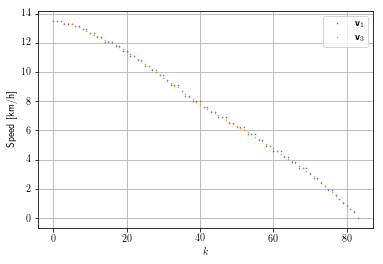

In [80]:
# Show warping path between v1 and v3
d.dtw(V[0], V[2])
wx, wy = d.compute_warpings()
plt.plot(V[0][wx], '.', label=r'$\textbf{v}_1$', ms=1)
plt.plot(V[2][wy], '.', label=r'$\textbf{v}_3$', ms=1)
plt.xlabel('$k$')
plt.ylabel('Speed [km/h]')
plt.grid('on')
plt.legend()
tikz('dtw_warped_series')

In [34]:
# With sakoeband
d = DynamicTimeWarping(scale_score=True, sakoeband=20)
table_distance(V, d.dtw)

         1       2       3       4
 1             inf     inf 4.7e+00
 2     inf         5.7e-03     inf
 3     inf 5.7e-03             inf
 4 4.7e+00     inf     inf        


In [35]:
# With Itakura parallelogram
d = DynamicTimeWarping(scale_score=True, ikaturaband=3)
table_distance(V, d.dtw)

         1       2       3       4
 1         1.0e-02 6.2e-03 5.0e+00
 2 1.0e-02         7.2e-03     inf
 3 6.2e-03 7.2e-03             inf
 4 5.3e+00     inf     inf        


In [36]:
# Initialize normal dtw for comparison
dtw = DynamicTimeWarping(scale_score=True)

## Compare all feature-based methods

In [37]:
with open(os.path.join(table_folder, 'feature_based.tex'), 'w') as f:
    write(f, '\\begin{tabular}{ccccccl}\n')
    write(f, '    \\toprule\n')
    write(f, '    \\multicolumn{2}{c}{Time series} & \\multicolumn{2}{c}{Features based}')
    write(f, ' & \\multicolumn{2}{c}{Model based} & Dynamic \\\\\n')
    write(f, '    \\textbf{x} & \\textbf{y} & Fourier & Custom & Auto & Splines & time \\\\\n')
    write(f, '    & & coefficients & features & regression & warping \\\\\n')
    write(f, ' \\otoprule\n')
    for i, x in enumerate(V):
        for j, y in enumerate(V):
            if j > i:
                write(f, '    $\\profile{{{:d}}}$ & $\\profile{{{:d}}}$'.format(i+1, j+1))
                write(f, ' & ${:.2f}$'.format(fourier_based_distance(x, y, w=FCweights)))
                write(f, ' & ${:.2f}$'.format(parameter_based_distance(x, y, w=par_weights)))
                write(f, ' & ${:.2f}$'.format(ar_distance(x, y, w=ar_weights)))
                write(f, ' & ${:.2f}$'.format(spl_distance(x, y, w=spl_weights)))
                write(f, ' & ${:s}$ \\\\\n'.format(str_e(dtw.dtw(x, y), decimals=2)))
    write(f, '    \\bottomrule\n')
    write(f, '\\end{tabular}\n')

\begin{tabular}{ccccccl}
    \toprule
    \multicolumn{2}{c}{Time series} & \multicolumn{2}{c}{Features based} & \multicolumn{2}{c}{Model based} & Dynamic \\
    \textbf{x} & \textbf{y} & Fourier & Custom & Auto & Splines & time \\
    & & coefficients & features & regression & warping \\
 \otoprule
    $\profile{1}$ & $\profile{2}$ & $5.22$ & $1.01$ & $0.53$ & $0.23$ & $9.71 \cdot 10^{-3}$ \\
    $\profile{1}$ & $\profile{3}$ & $5.49$ & $1.22$ & $1.13$ & $0.25$ & $6.19 \cdot 10^{-3}$ \\
    $\profile{1}$ & $\profile{4}$ & $5.03$ & $2.41$ & $2.67$ & $2.86$ & $4.73$ \\
    $\profile{2}$ & $\profile{3}$ & $0.30$ & $0.24$ & $1.52$ & $0.07$ & $5.72 \cdot 10^{-3}$ \\
    $\profile{2}$ & $\profile{4}$ & $0.46$ & $2.75$ & $2.16$ & $2.46$ & $4.46$ \\
    $\profile{3}$ & $\profile{4}$ & $0.63$ & $2.95$ & $3.64$ & $2.60$ & $5.07$ \\
    \bottomrule
\end{tabular}
